## 1) Data Analysis

In [1]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[1]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nShapes:")
for key, tensor in sample.items():
    if key == "scene_idx" or key == "grasp_idx":
        continue
    print(f"{key}: {tensor.shape}")

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if key == "scene_idx" or key == "grasp_idx" or key == "score":
        continue
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()

print(f"Score: {sample['score']}")


Sample contains the following keys:
- sdf
- grasp
- score
- scene_idx
- grasp_idx

Shapes:
sdf: torch.Size([48, 48, 48])
grasp: torch.Size([19])
score: torch.Size([])

Basic statistics:
sdf:
  Min: -0.7169
  Max: 1.4683
  Mean: 0.6416
  Std: 0.2782

grasp:
  Min: -0.2937
  Max: 1.8255
  Mean: 0.3404
  Std: 0.5473

Score: 0.33304598927497864


## 2) Overfitting on 1 sample

In [2]:
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import math

### 2.1) Initialize the model

In [3]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1222049


### 2.2) Get a small number of samples

In [4]:
# Create dataset
data_path = Path('data/processed')

dataset = GraspDataset(data_path)
print("len(dataset): ", len(dataset))

def get_samples(dataset, num_samples):
    # Get num_samples many unique indices
    indices = torch.randperm(len(dataset))[:num_samples]
    samples = []
    print("Scene indices: ", indices)
    for i in indices:
        # Choose random grasp from scene
        sample = dataset[i]
        samples.append(sample)
    return samples

samples = get_samples(dataset, 10)

for i, sample in enumerate(samples[:3]):
    print(f"Sample {i}:")
    print("\tgrasp: ", sample['grasp'].tolist())
    print("\tscore: ", sample['score'].item())


print(samples[0]['grasp'].shape)
print(samples[0]['score'].shape)
print(samples[0]['sdf'].shape)



len(dataset):  7462560
Scene indices:  tensor([6434734, 1415756, 6454909, 3504589, 4936646, 2858591, 4715063, 6732764,
        5602664, 7244770])
Sample 0:
	grasp:  [-0.17773474752902985, -0.13397440314292908, 0.11592119932174683, 0.10246924310922623, 0.748285174369812, 0.3893835246562958, 0.527209460735321, 0.4079841077327728, 1.50093412399292, 1.8254671096801758, 0.2915802299976349, -0.05906585976481438, 0.393803209066391, 0.0885569304227829, 1.3209340572357178, -0.008675945922732353, 0.21476003527641296, -0.20906585454940796, 0.3854670822620392]
	score:  0.45679938793182373
Sample 1:
	grasp:  [-0.10872942209243774, -0.022228188812732697, 0.25476232171058655, 0.3320675194263458, 0.9113627672195435, 0.11923542618751526, 0.2119717001914978, 0.2713175415992737, 1.50093412399292, 1.8254671096801758, 0.20595623552799225, -0.1890658587217331, 0.33976852893829346, -0.11889589577913284, -0.08906585723161697, 0.15351073443889618, -0.16655132174491882, 0.42093414068222046, -0.12737423181533813

### 2.3) Overfit on these samples from that one scene

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]

[30.213095445930957, 30.17613944709301, 30.140928127244116, 30.10498683191836, 30.064901734143497, 30.019593432545662, 29.96413327381015, 29.88636036515236, 29.787068662047385, 29.661893146671353, 29.498111535608768, 29.275163830723614, 28.945327473036013, 28.47462726091617, 27.815033997036515, 26.928245482733473, 25.780516917724164, 24.40930692161164, 22.89796670973301, 21.432868725061418, 20.199880182743073, 19.313104772567748, 18.779938650131225, 18.515143358707427, 18.408401930332182, 18.374997633695603, 18.365033304691316, 18.359399539232253, 18.353754663467406, 18.346991288661957, 18.33936430811882, 18.331372332572936, 18.323292607069014, 18.31518428325653, 18.30724799633026, 18.29951393008232, 18.292058396339417, 18.2846337556839, 18.277375549077988, 18.270353263616563, 18.263527697324754, 18.256849122047424, 18.25041260123253, 18.244199448823927, 18.23817797899246, 18.232317131757735, 18.226603639125823, 18.22102197408676, 18.215558129549027, 18.210184347629546, 18.204899799823

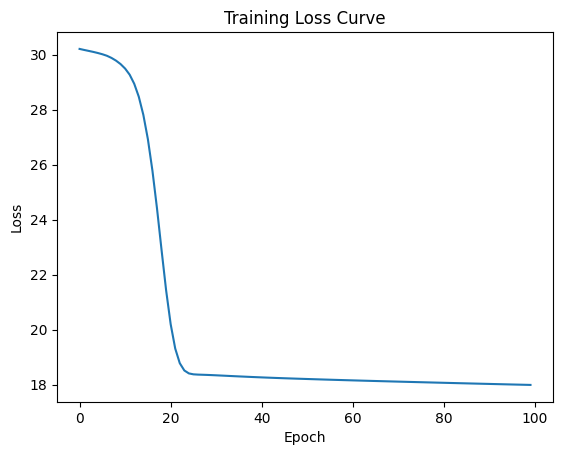

In [5]:
EPOCHS = 100

losses = []

# Play around with the learning rate and run this cell multiple times 
# to see how it affects the loss curve
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    for sample in samples:
        optimizer.zero_grad()
        sdf_features = model.encode_sdf(sample['sdf'])
        flattened_features = torch.cat([sdf_features, sample['grasp']])
        pred_quality = model(flattened_features).squeeze()
        loss = criterion(pred_quality, sample['score'])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(samples)
    losses.append(epoch_loss)

print(losses)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


## 3) Full Training

### 3.2) Create the datasets

In [6]:
import random

# Load the dataset
dataset = GraspDataset(data_path)

# Split dataset into training and validation
val_split = 0.2
num_samples = len(dataset)
train_size = int(num_samples * (1 - val_split))
val_size = num_samples - train_size

print(f"Subset samples: {num_samples}, Calculated train size: {train_size}, Calculated val size: {val_size}")

# Shuffle indices
random.seed(42)
indices = list(range(num_samples))
random.shuffle(indices)

# Split indices
train_indices = indices[:1000]
val_indices = indices[-100:]

# Create Subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Subset samples: 7462560, Calculated train size: 5970048, Calculated val size: 1492512
Train dataset size: 1000, Validation dataset size: 100


In [7]:
import random
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
import torch

# --- Configuration ---
LEARNING_RATE = 1e-3
EPOCHS = 100
VAL_SPLIT = 0.2
BASE_CHANNELS = 4
FC_DIMS = [32, 8]
BATCH_SIZE = 32
NUM_WORKERS = 1

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Dataset and Dataloaders ---
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

num_samples = len(dataset)
train_size = int(num_samples * (1 - VAL_SPLIT))
val_size = num_samples - train_size
print(f"Total scenes: {num_samples}, Train scenes: {train_size}, Val scenes: {val_size}")

indices = list(range(num_samples))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:5000]
val_indices = indices[-1000:]

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
print(f"Train dataset size: {len(train_set)}, Validation dataset size: {len(val_set)}")

# The dataloader now yields your desired batches directly!
# batch_size=None is important for iterable datasets that do their own batching.
pin_memory = torch.cuda.is_available()
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=True)

# --- Model, Optimizer, Loss ---
model = GQEstimator(input_size=48, base_channels=BASE_CHANNELS, fc_dims=FC_DIMS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# --- Training Loop ---
print(f"\nStarting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    num_steps = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training"):
        optimizer.zero_grad()

        # Move to device
        sdf_batch = batch['sdf'].to(device)
        grasp_batch = batch['grasp'].to(device)
        score_batch = batch['score'].to(device)

        # Get the actual batch size (handles variable batch sizes)
        actual_batch_size = sdf_batch.size(0)

        # 1. Encode SDF
        sdf_features = model.encode_sdf(sdf_batch)

        # 2. No need to expand - sdf_features is already (B, flattened_size)
        # 3. Concatenate features
        flattened_features = torch.cat([sdf_features, grasp_batch], dim=1)

        # 4. Predict grasp quality and compute loss
        pred_quality = model(flattened_features)
        loss = criterion(pred_quality, score_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * actual_batch_size
        num_steps += actual_batch_size

    scheduler.step()

    avg_train_loss = total_train_loss / num_steps

    # --- Validation Loop ---
    model.eval()
    total_val_loss = 0
    num_steps = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation"):
            sdf_batch = batch['sdf'].to(device)
            grasp_batch = batch['grasp'].to(device)
            score_batch = batch['score'].to(device)

            # Get the actual batch size (handles variable batch sizes)
            actual_batch_size = sdf_batch.size(0)

            # 1. Encode SDF
            sdf_features = model.encode_sdf(sdf_batch)

            # 2. No need to expand - sdf_features is already (B, flattened_size)
            # 3. Concatenate features
            flattened_features = torch.cat([sdf_features, grasp_batch], dim=1)

            # 4. Predict grasp quality and compute loss
            pred_quality = model(flattened_features)
            loss = criterion(pred_quality, score_batch)

            total_val_loss += loss.item() * actual_batch_size
            num_steps += actual_batch_size

    avg_val_loss = total_val_loss / num_steps
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# --- Save Model ---
model_path = "model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully to {model_path}")

Using device: cpu
Total scenes: 7462560, Train scenes: 5970048, Val scenes: 1492512
Train dataset size: 5000, Validation dataset size: 1000
Initializing GQEstimator
Input size: 48
Flattened size: 864
Number of parameters: 46873

Starting training for 100 epochs...


Epoch 1/100 Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Epoch [1/100], Train Loss: 49.9691, Val Loss: 48.7680


Epoch 2/100 Validation: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s]


Epoch [2/100], Train Loss: 43.0461, Val Loss: 42.0795


Epoch 3/100 Validation:  56%|█████▋    | 18/32 [00:02<00:01,  7.08it/s]


KeyboardInterrupt: 

In [8]:
import time
from dataset import OptimizedGraspDataset

class Args:
    def __init__(self):
        # Training parameters
        self.lr = 1e-4
        self.epochs = 100
        self.train_size = 5000
        self.val_size = 1000
        self.base_channels = 4
        self.fc_dims = [32, 16]
        self.batch_size = 32
        self.num_workers = 0
        self.data_path = 'data/processed'
        self.weight_decay = 1e-4
        self.early_stopping_patience = 15
        self.check_data_distribution = False
        
        # WandB parameters
        self.wandb_entity = 'tairo'
        self.project_name = 'adlr'
        self.run_name = None

# Create args object
args = Args()

class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

def collect_unique_scene_indices(dataloader):
    """
    Collect all unique scene indices that will be used in this epoch.
    
    Args:
        dataloader: DataLoader that yields batches with scene_idx
    
    Returns:
        set: Set of unique scene indices
    """
    unique_scenes = set()
    for batch in dataloader:
        scene_indices = batch['scene_idx']
        unique_scenes.update(scene_indices.tolist())
    return unique_scenes

def preprocess_epoch_sdfs(unique_scene_indices, dataset, model, device):
    """
    Pre-encode all unique SDFs for the epoch.
    
    Args:
        unique_scene_indices: Set of unique scene indices
        dataset: Dataset to get SDFs from
        model: Model with encode_sdf method
        device: Device to move tensors to
    
    Returns:
        dict: Mapping from scene_idx to encoded SDF features
    """
    sdf_features_cache = {}
    
    print(f"Pre-encoding {len(unique_scene_indices)} unique SDFs for this epoch...")
    with torch.no_grad():  # No gradients needed for SDF encoding
        for scene_idx in tqdm(unique_scene_indices, desc="Encoding SDFs"):
            sdf = dataset.get_sdf(scene_idx).to(device)
            sdf_features = model.encode_sdf(sdf)
            sdf_features_cache[scene_idx] = sdf_features.detach()  # Store on GPU
    
    return sdf_features_cache

def process_batch_with_cached_features(batch, sdf_features_cache, device):
    """
    Process batch using pre-computed SDF features.
    
    Args:
        batch: Batch from dataloader
        sdf_features_cache: Pre-computed SDF features
        device: Device
    
    Returns:
        tuple: (sdf_features_batch, grasp_batch, score_batch)
    """
    scene_indices = batch['scene_idx']
    grasp_batch = batch['grasp'].to(device)
    score_batch = batch['score'].to(device)
    
    # Build batch of SDF features by lookup
    batch_size = len(scene_indices)
    feature_dim = next(iter(sdf_features_cache.values())).shape[0]
    sdf_features_batch = torch.zeros(batch_size, feature_dim, device=device)
    
    for i, scene_idx in enumerate(scene_indices):
        sdf_features_batch[i] = sdf_features_cache[scene_idx.item()]
    
    return sdf_features_batch, grasp_batch, score_batch

def main(args):
    # --- Device Setup ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- Dataset and Dataloaders ---
    data_path = Path(args.data_path)
    dataset = OptimizedGraspDataset(data_path)

    num_samples = len(dataset)
    print(f"Total samples: {num_samples}")

    # Create indices and shuffle
    indices = list(range(num_samples))
    random.seed(42)
    random.shuffle(indices)

    # Split into train and validation
    train_indices = indices[:args.train_size]
    val_indices = indices[-args.val_size:]

    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    print(f"Train dataset size: {len(train_set)}, Validation dataset size: {len(val_set)}")

    if args.check_data_distribution:
        # Data distribution analysis
        print("\n=== Data Distribution Analysis ===")
        train_scores = []
        val_scores = []

        for i in range(len(train_set)):
            train_scores.append(train_set[i]['score'].item())
            
        for i in range(len(val_set)):
            val_scores.append(val_set[i]['score'].item())

        train_scores = np.array(train_scores)
        val_scores = np.array(val_scores)

        print(f"Train scores - Mean: {train_scores.mean():.3f}, Std: {train_scores.std():.3f}")
        print(f"Val scores   - Mean: {val_scores.mean():.3f}, Std: {val_scores.std():.3f}")
        print(f"Distribution difference: {abs(train_scores.mean() - val_scores.mean()):.3f}")
        print("===================\n")

    # Create DataLoaders
    pin_memory = torch.cuda.is_available()
    train_loader = DataLoader(
        train_set, 
        batch_size=args.batch_size, 
        num_workers=args.num_workers, 
        pin_memory=pin_memory, 
        persistent_workers=True if args.num_workers > 0 else False,
        shuffle=True  # Important: shuffle for training
    )
    val_loader = DataLoader(
        val_set, 
        batch_size=args.batch_size, 
        num_workers=args.num_workers, 
        pin_memory=pin_memory, 
        persistent_workers=True if args.num_workers > 0 else False,
        shuffle=False  # No shuffle for validation
    )

    # --- Model, Optimizer, Loss ---
    model = GQEstimator(input_size=48, base_channels=args.base_channels, fc_dims=args.fc_dims).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    criterion = torch.nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=10
    )
    
    # Early stopping
    early_stopping = EarlyStopping(patience=args.early_stopping_patience)

    # --- Training Loop ---
    print(f"Starting training for {args.epochs} epochs...")
    best_val_loss = float('inf')
    
    for epoch in range(args.epochs):
        # === EPOCH-LEVEL SDF PREPROCESSING ===
        print(f"\n=== Epoch {epoch+1}/{args.epochs} ===")
        
        # Collect unique scene indices for this epoch
        start_time = time.time()
        train_unique_scenes = collect_unique_scene_indices(train_loader)
        val_unique_scenes = collect_unique_scene_indices(val_loader)
        collection_time = time.time() - start_time
        
        print(f"Train unique scenes: {len(train_unique_scenes)}")
        print(f"Validation unique scenes: {len(val_unique_scenes)}")
        print(f"Scene collection time: {collection_time:.2f}s")
        
        # Pre-encode all unique SDFs
        start_time = time.time()
        train_sdf_cache = preprocess_epoch_sdfs(train_unique_scenes, dataset, model, device)
        val_sdf_cache = preprocess_epoch_sdfs(val_unique_scenes, dataset, model, device)
        preprocessing_time = time.time() - start_time
        
        print(f"SDF preprocessing time: {preprocessing_time:.2f}s")
        
        # Calculate efficiency metrics
        total_train_samples = len(train_set)
        total_val_samples = len(val_set)
        train_efficiency = len(train_unique_scenes) / total_train_samples
        val_efficiency = len(val_unique_scenes) / total_val_samples
        
        print(f"Train efficiency: {train_efficiency:.3f} (lower is better)")
        print(f"Val efficiency: {val_efficiency:.3f} (lower is better)")
        print(f"Train SDF reuse factor: {total_train_samples / len(train_unique_scenes):.1f}x")
        print(f"Val SDF reuse factor: {total_val_samples / len(val_unique_scenes):.1f}x")
        
        # === TRAINING ===
        model.train()
        total_train_loss = 0
        num_steps = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs} Training")
        for batch in pbar:
            optimizer.zero_grad()

            # Fast batch processing with cached SDF features
            sdf_features_batch, grasp_batch, score_batch = process_batch_with_cached_features(
                batch, train_sdf_cache, device
            )

            actual_batch_size = sdf_features_batch.size(0)

            # Concatenate and predict
            flattened_features = torch.cat([sdf_features_batch, grasp_batch], dim=1)
            pred_quality = model(flattened_features)
            loss = criterion(pred_quality, score_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            total_train_loss += loss.item() * actual_batch_size
            num_steps += actual_batch_size
            
            # Update progress bar
            running_loss = total_train_loss / num_steps
            pbar.set_postfix(loss=f'{running_loss:.4f}')

        avg_train_loss = total_train_loss / num_steps

        # === VALIDATION ===
        model.eval()
        total_val_loss = 0
        num_steps = 0
        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{args.epochs} Validation")
            for batch in pbar_val:
                # Fast batch processing with cached SDF features
                sdf_features_batch, grasp_batch, score_batch = process_batch_with_cached_features(
                    batch, val_sdf_cache, device
                )

                actual_batch_size = sdf_features_batch.size(0)

                # Concatenate and predict
                flattened_features = torch.cat([sdf_features_batch, grasp_batch], dim=1)
                pred_quality = model(flattened_features)
                loss = criterion(pred_quality, score_batch)

                total_val_loss += loss.item() * actual_batch_size
                num_steps += actual_batch_size
                
                # Update progress bar
                running_val_loss = total_val_loss / num_steps
                pbar_val.set_postfix(val_loss=f'{running_val_loss:.4f}')

        avg_val_loss = total_val_loss / num_steps
        
        # Clear SDF caches to free GPU memory
        del train_sdf_cache, val_sdf_cache
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        # Step the scheduler
        scheduler.step(avg_val_loss)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch [{epoch+1}/{args.epochs}], LR: {current_lr:.2e}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        # Early stopping check
        if early_stopping(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

main(args)

Using device: cpu
Total samples: 7462560
Train dataset size: 5000, Validation dataset size: 1000
Initializing GQEstimator
Input size: 48
Flattened size: 864
Number of parameters: 47145
Starting training for 100 epochs...

=== Epoch 1/100 ===


KeyboardInterrupt: 